# Combining Supervised Machine Learning Techniques for Heart Disease Prediction
CSC 6850: Machine Learning
Final Project Code

Aysha Rahman, Debra Ritter, and Shruti Dabhi

In order to run this code, simply click "Run all"

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fedesoriano_heart_failure_prediction_path = kagglehub.dataset_download('fedesoriano/heart-failure-prediction')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
# For baseline models and evaluation metrics
import sklearn.dummy
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
# For data preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
# For ML tasks
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
      path = os.path.join(dirname, filename)
      print(path)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Exploratory Data Analysis

In [ ]:
df = pd.read_csv(path)

# For visualization
df_vis = df.copy()

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df.nunique()

,0
Age,50
Sex,2
ChestPainType,4
RestingBP,67
Cholesterol,222
FastingBS,2
RestingECG,3
MaxHR,119
ExerciseAngina,2
Oldpeak,53


We have no null samples, which saves us from having to do imputation.

## Data Preparation
In order to prepare our data, we encode categorical labels and detect and handle outliers.


### Encode categorical data
From the ```df.info()``` function above, we learn that we have 5 categorical variables: Sex, ChestPainType, RestingECG, ExerciseAngina, and ST_Slope. We encode the categorical data as numerical labels using the scikit-kearn ```LabelEncoder()``` function.



In [ ]:
# Select columns with object data type
cat_vars = df.select_dtypes(include=['object']).columns.tolist()
print(cat_vars)
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
print(num_vars)

# Encode labels
le = LabelEncoder()
for c in cat_vars:
  df[c] = le.fit_transform(df[c])
df

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


## Visualizations
Our initial visualizations include:
*   Histograms with Kernel Density Estimate (KDE) curves for numerical features to visualize distributions and understand spread and skewness
*   A pairplot to view each feature against the other
*   A correlation heatmap

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

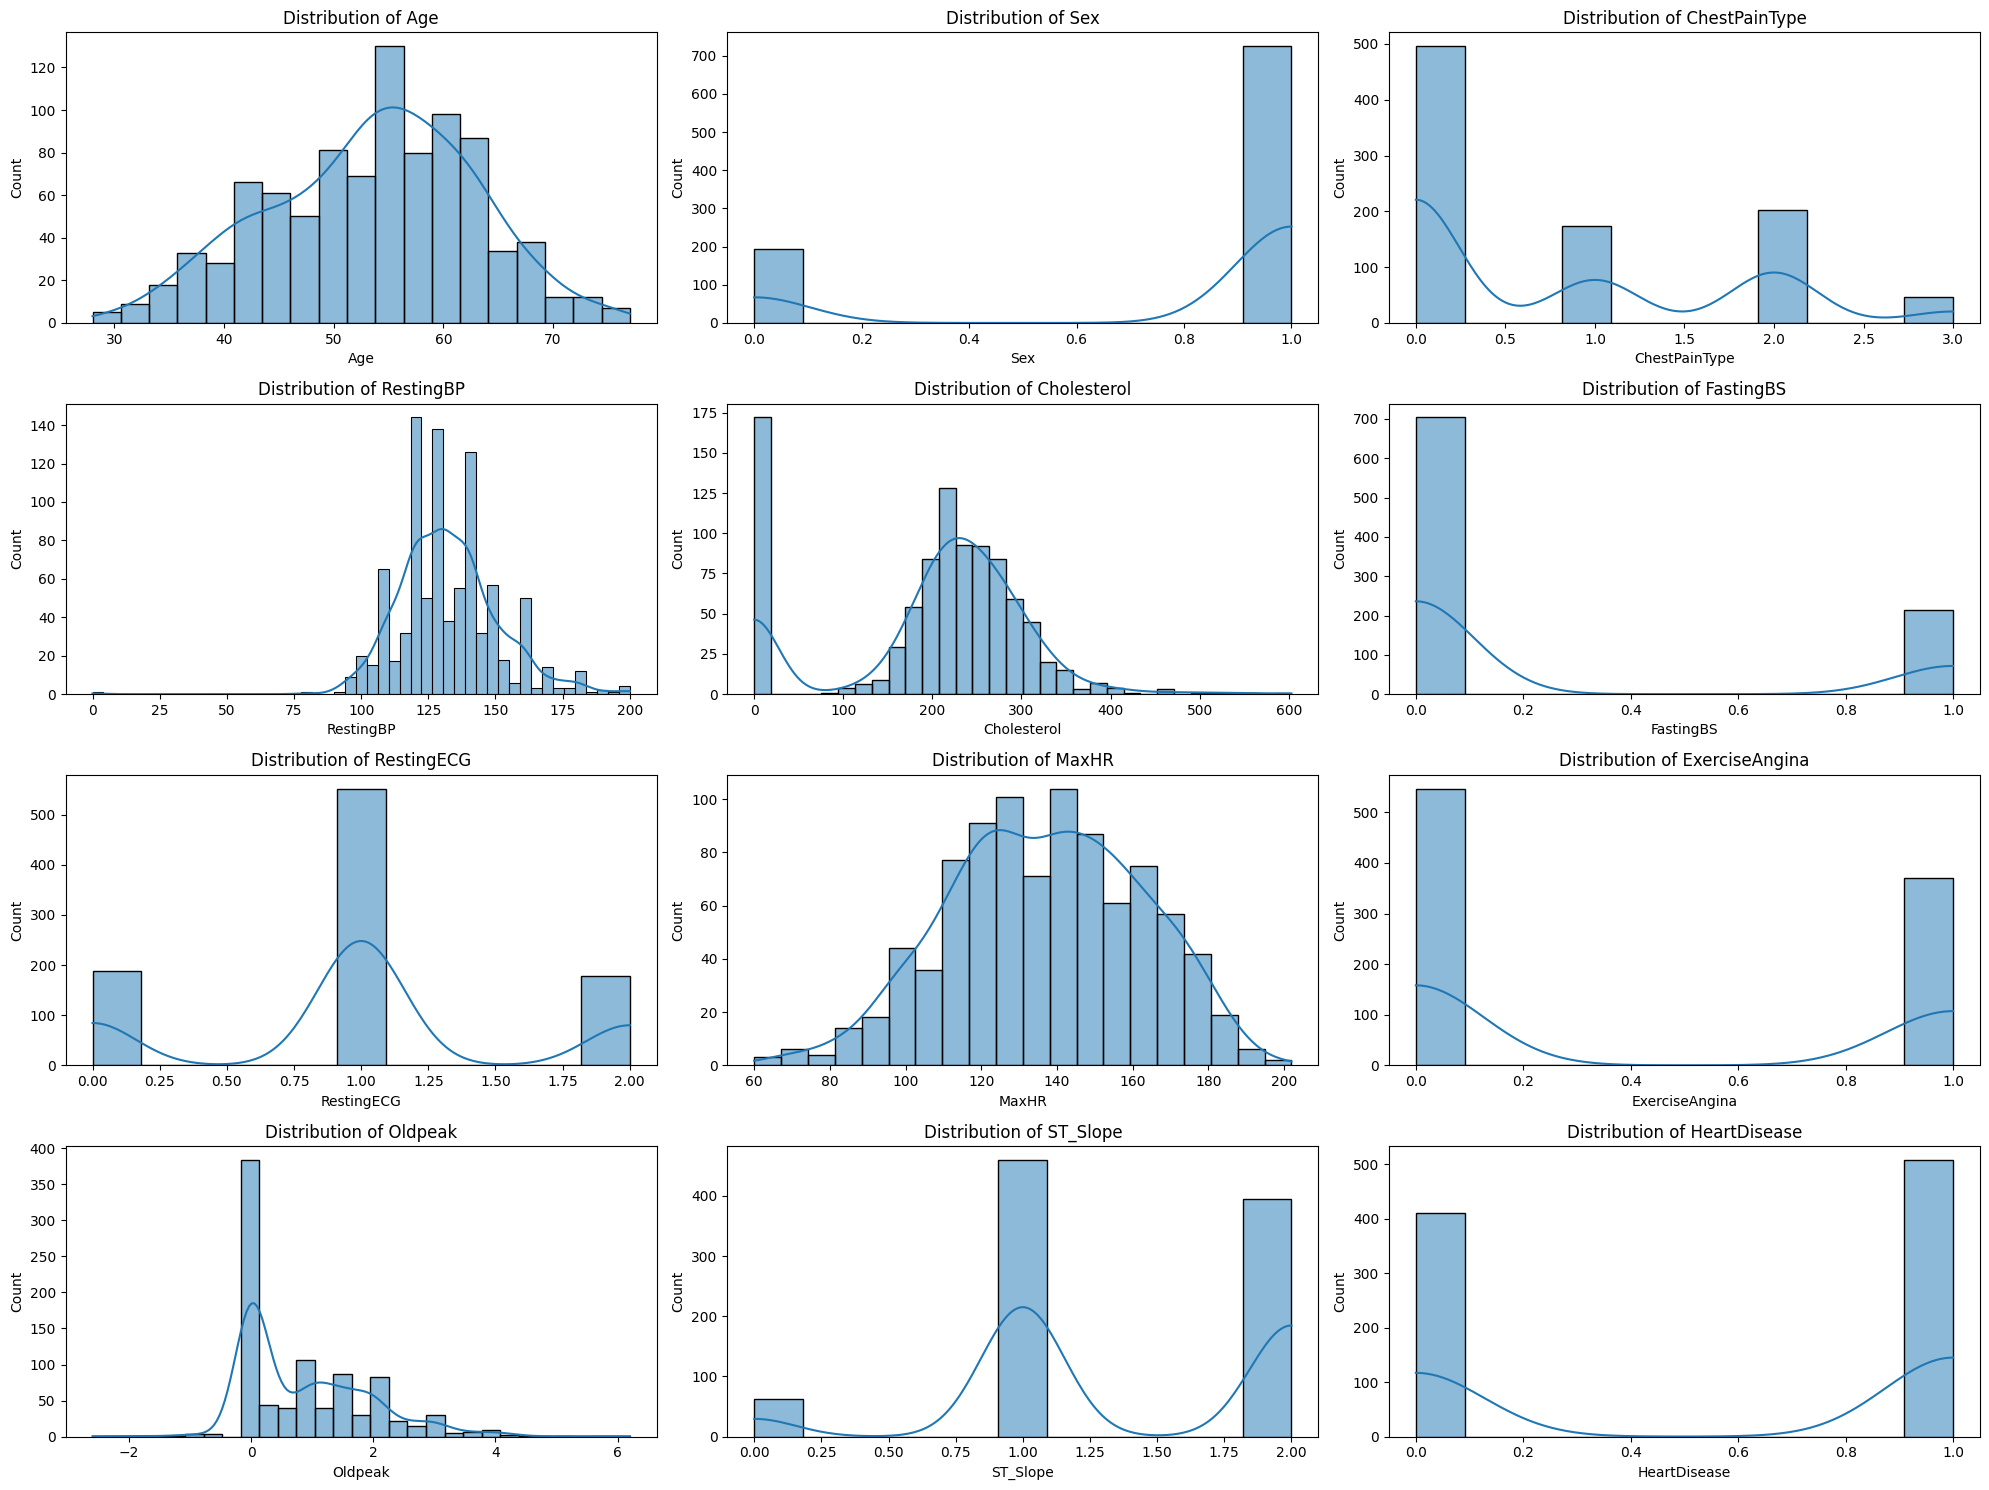

In [ ]:
##  Histograms  ##

# Visualize distributions of key numerical variables
plt.figure(figsize=(20, 15))

# Select numerical columns for visualization
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(numerical_cols)

# Create a subplot grid
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

Notice that there are a lot of zero values for the ```'Cholesterol'``` column, which is concerning.

In [ ]:
# See whether people with 0 cholesterol values are healthy or have heart disease
print("Missing cholesterol when healthy:",len(df[(df['Cholesterol']==0) & (df['HeartDisease']==0)]))
print("Missing cholesterol when heart disease:",(len(df[(df['Cholesterol']==0) & (df['HeartDisease']==1)])))


Missing cholesterol when healthy: 20
Missing cholesterol when heart disease: 152


['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


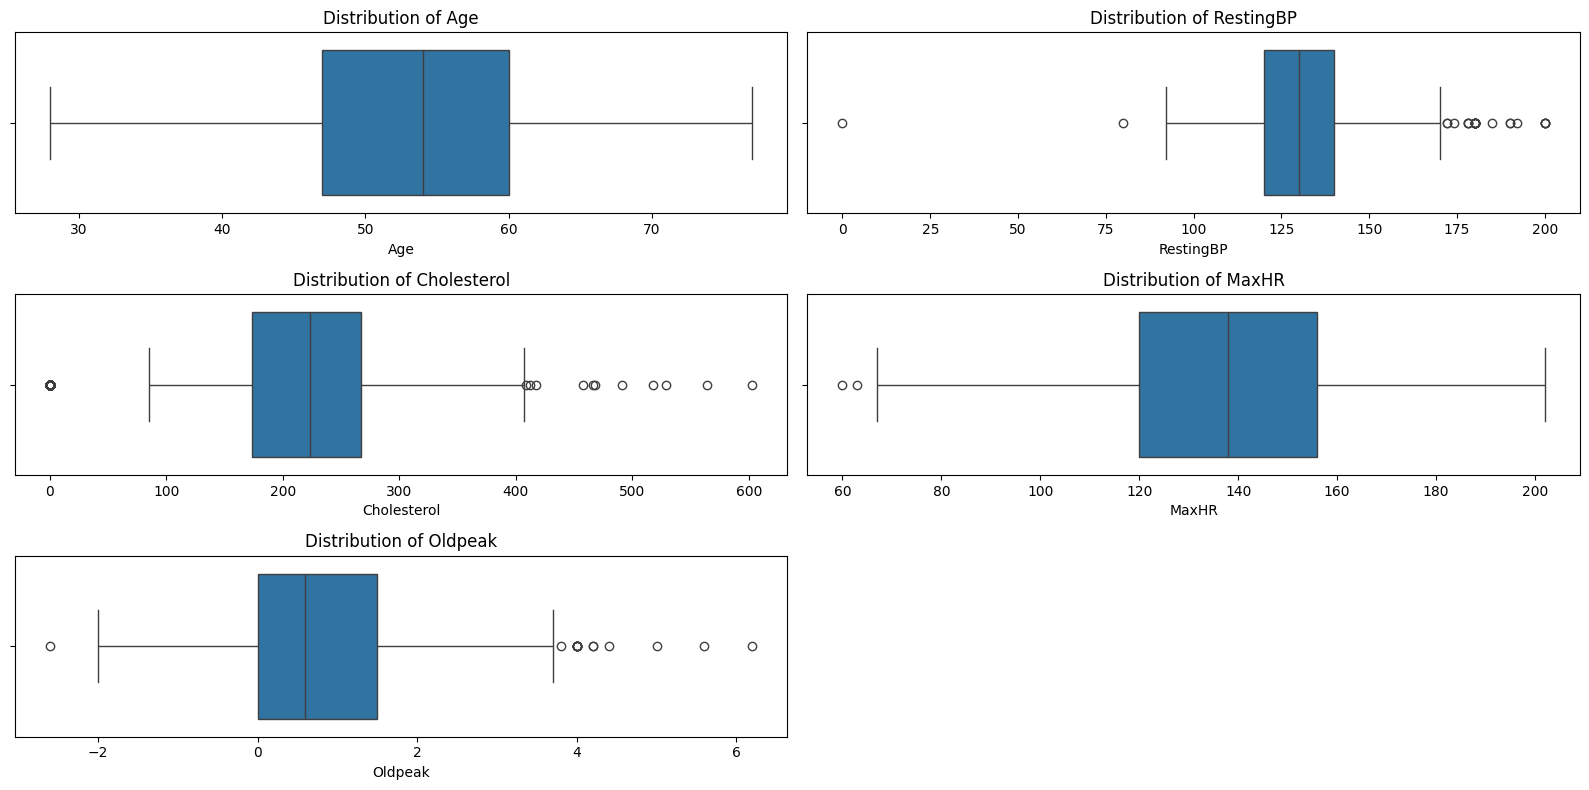

In [ ]:
##  Boxplots  ##

# Create figure
plt.figure(figsize=(16, 8))
# Continuous variables
unique_counts = df.nunique()
cont_cols = unique_counts[unique_counts > 5].index.tolist()
print(cont_cols)
# Create a subplot grid
n_cols = 2
n_rows = ((len(cont_cols) + n_cols - 1) // n_cols)
for i, col in enumerate(cont_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

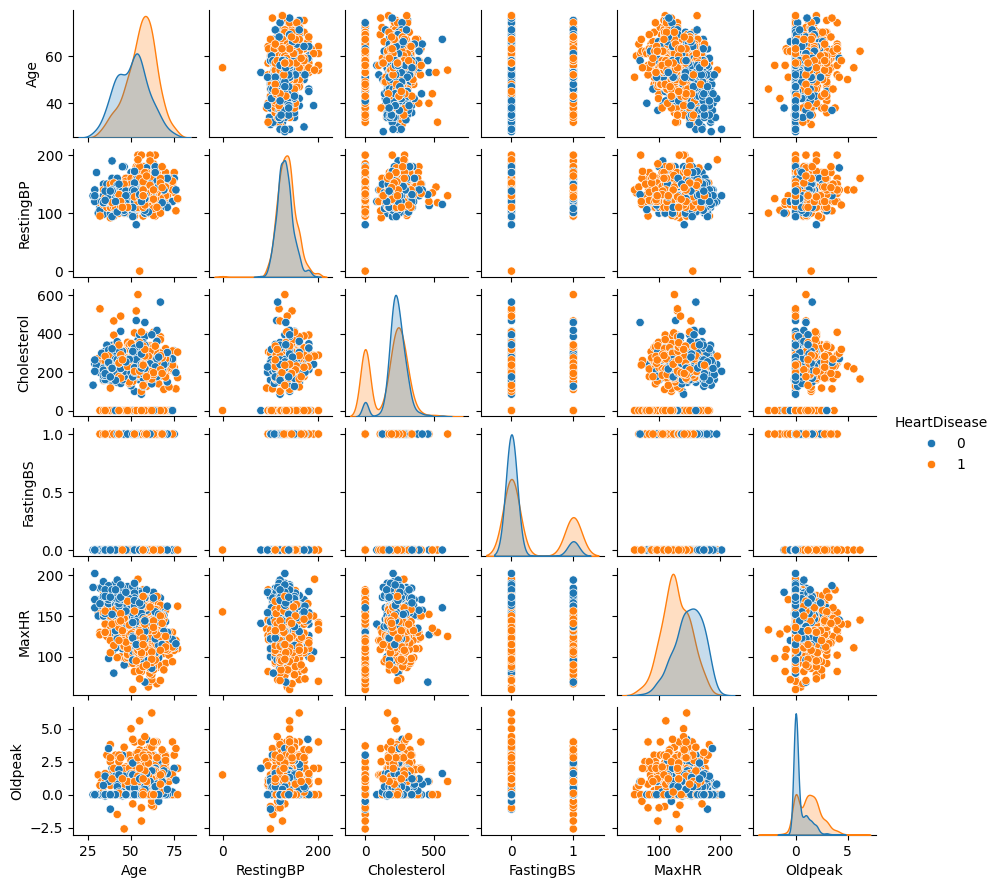

In [ ]:
# Pairplot to view each feature against the other
sns.pairplot(df_vis, hue='HeartDisease', height=1.5)

Some of the features seems to be correlated, such as the `age` column with other features.

<Axes: >

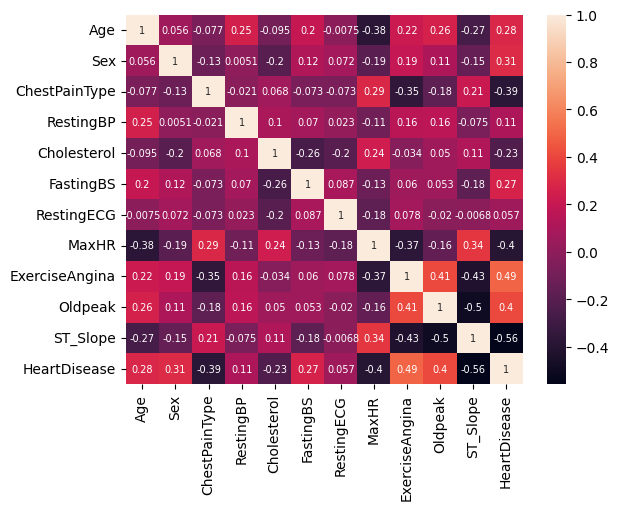

In [ ]:
# Correlation heatmap
corr = df.corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 7})

We see a negative correlation between cholesterol and heart disease, which does not make sense and is caused by the zero values in our ```'Cholesterol'``` column. This paints an inaccurate picture of the relationship between cholesterol and heart disease, so we will impute the missing/zero values of cholesterol with the median.

In [ ]:
# Calculate median based off of nonzero values
cholesterol_median = df['Cholesterol'][df['Cholesterol']!=0].median()
print(cholesterol_median)
# Find rows where cholesterol value is zero and replace cholesterol values with median
df.loc[df['Cholesterol']==0,'Cholesterol'] = cholesterol_median

# # Definitly don't do this, but out of curiosity: What if we drop the 0 rows?
# zero_count_cholesterol = (df['Cholesterol'] == 0).sum()
# print(f"Number of zeros in 'Cholesterol': {zero_count_cholesterol}")
# # 172 records have 0 for Cholesterol

# # Alternatively, try dropping cholesterol entirely
# df=df.drop('Cholesterol',axis=1)

237.0


['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

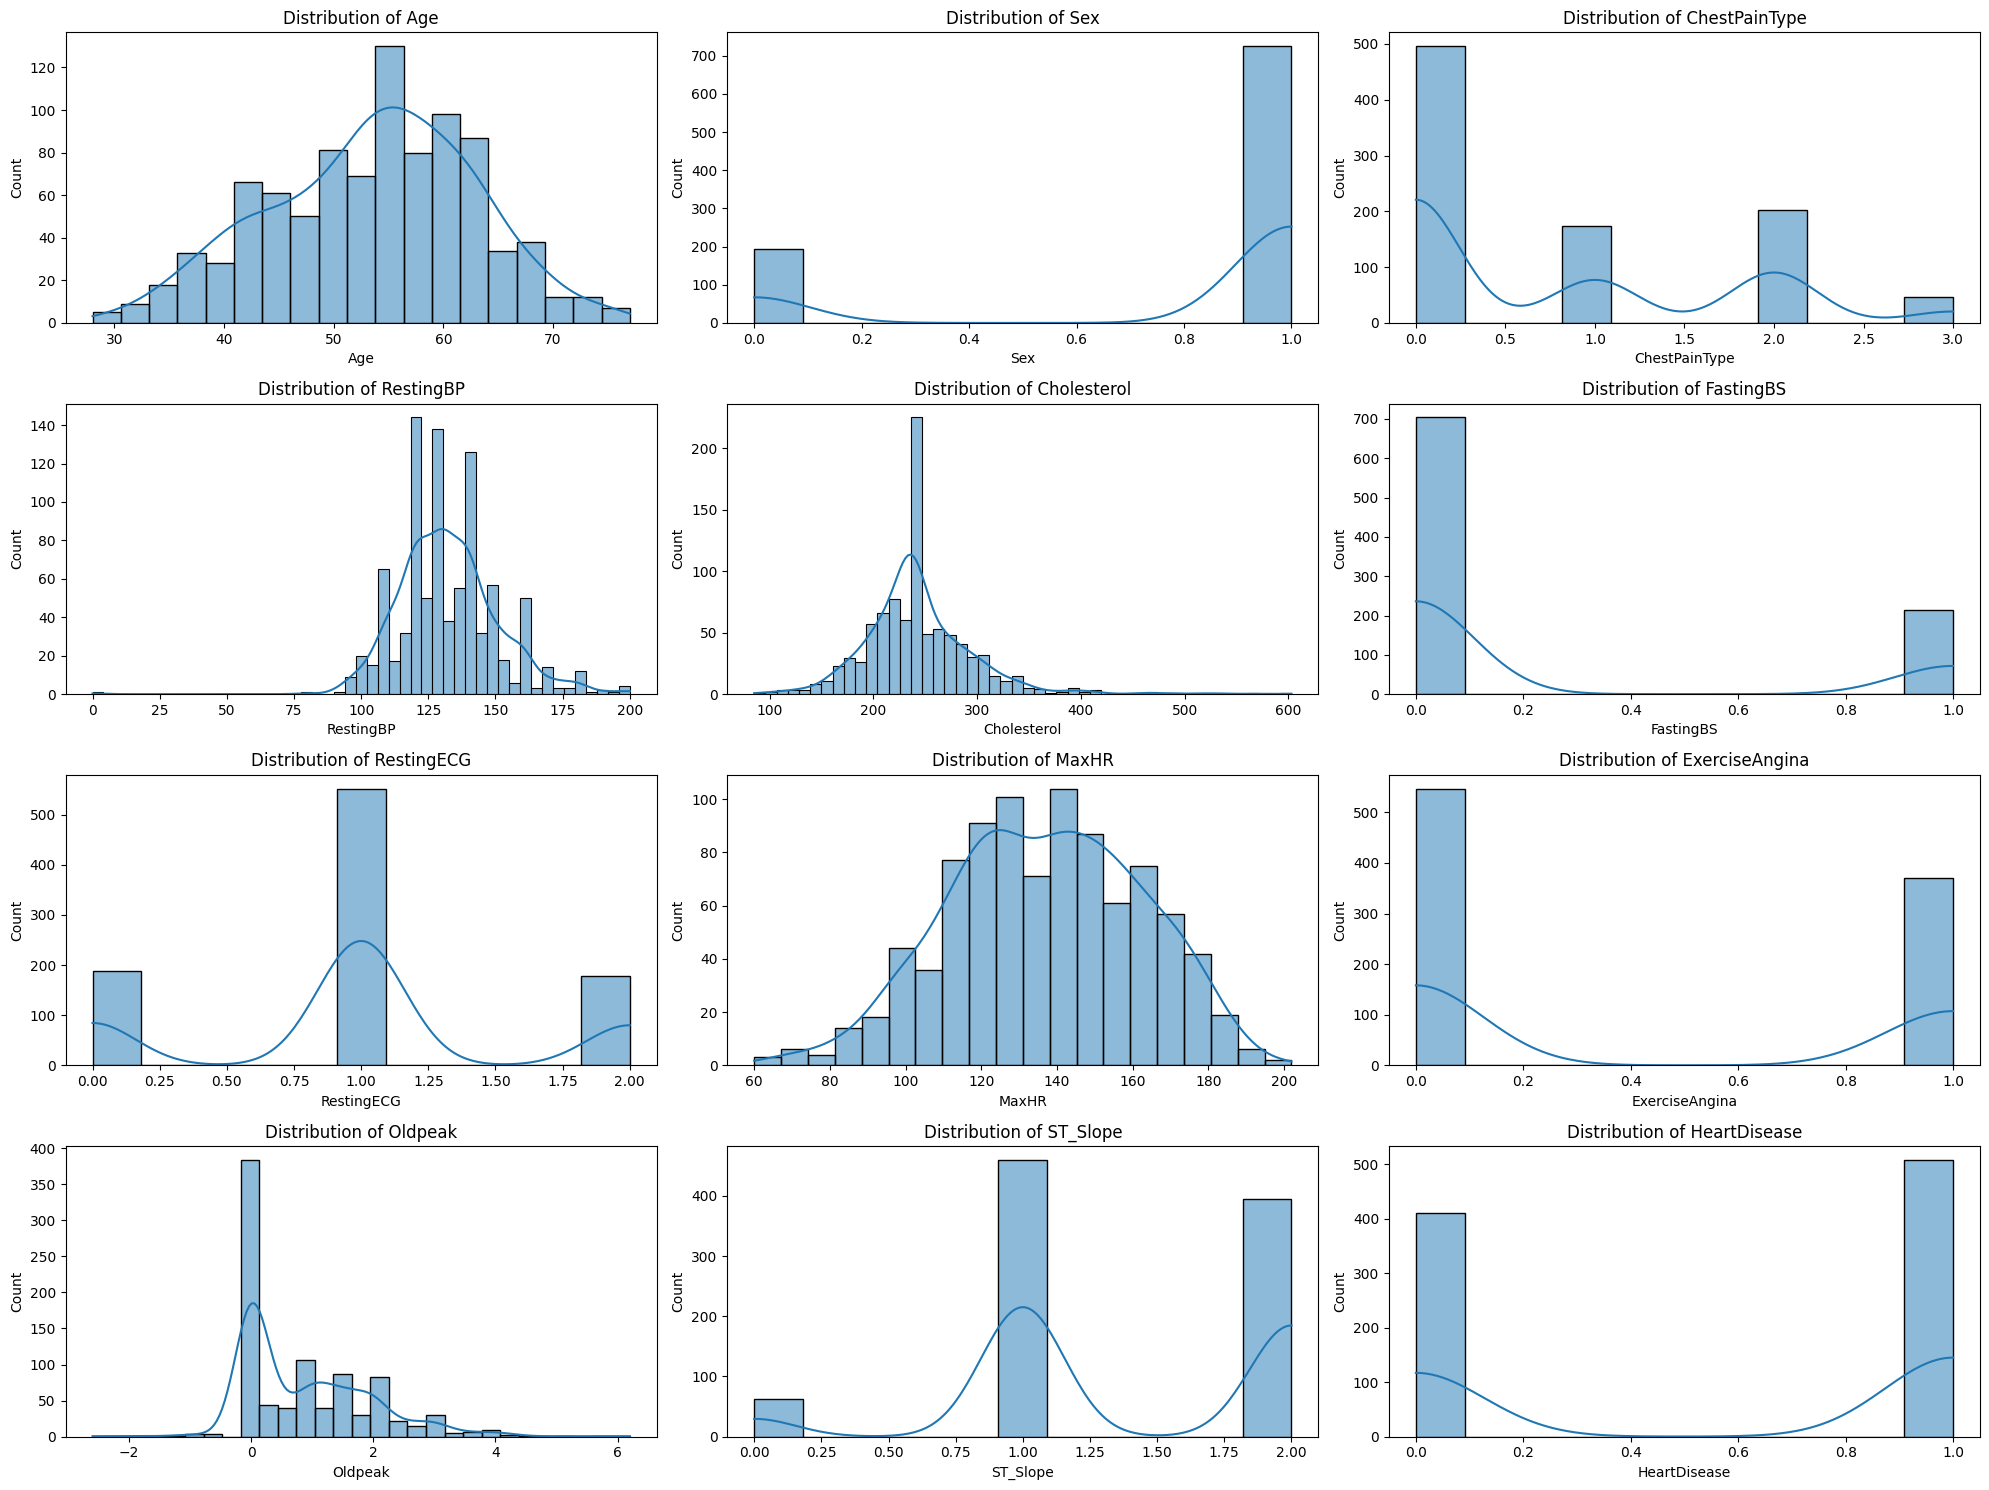

In [ ]:
# Now repeat visualizations

##  Histograms  ##

# Visualize distributions of key numerical variables
plt.figure(figsize=(20, 15))

# Select numerical columns for visualization
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(numerical_cols)

# Create a subplot grid
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

<Axes: >

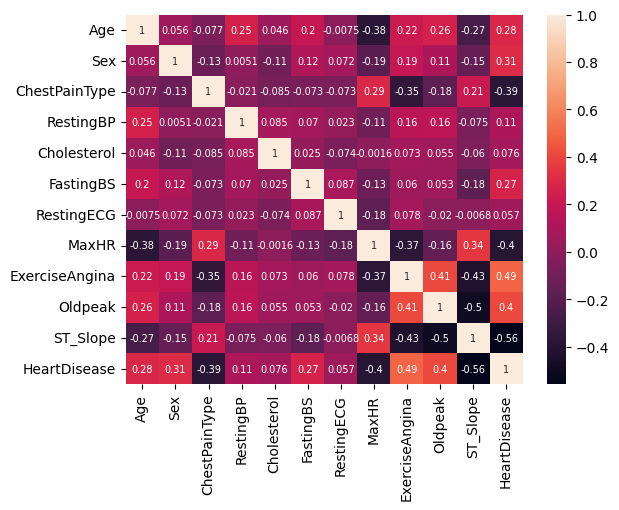

In [ ]:
# Correlation heatmap
corr = df.corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 7})

## PCA "by hand"
Although sk-learn already has a way to do PCA built-in, doing it manually allows us to better understand the data.

In [ ]:
# convert DataFrame to ndarray
data = df.to_numpy()
data

array([[40. ,  1. ,  1. , ...,  0. ,  2. ,  0. ],
       [49. ,  0. ,  2. , ...,  1. ,  1. ,  1. ],
       [37. ,  1. ,  1. , ...,  0. ,  2. ,  0. ],
       ...,
       [57. ,  1. ,  0. , ...,  1.2,  1. ,  1. ],
       [57. ,  0. ,  1. , ...,  0. ,  1. ,  1. ],
       [38. ,  1. ,  2. , ...,  0. ,  2. ,  0. ]])

In [ ]:
# Normalize the dataset
X = data[:, :-1]
X_norm = normalize(X)
display(X_norm)
X_norm.shape

array([[0.10914468, 0.00272862, 0.00272862, ..., 0.        , 0.        ,
        0.00545723],
       [0.16832228, 0.        , 0.0068703 , ..., 0.        , 0.00343515,
        0.00343515],
       [0.11260201, 0.0030433 , 0.0030433 , ..., 0.        , 0.        ,
        0.0060866 ],
       ...,
       [0.25354517, 0.00444816, 0.        , ..., 0.00444816, 0.00533779,
        0.00444816],
       [0.17497262, 0.        , 0.0030697 , ..., 0.        , 0.        ,
        0.0030697 ],
       [0.13347555, 0.00351251, 0.00702503, ..., 0.        , 0.        ,
        0.00702503]])

(918, 11)

In [ ]:
# Check that normalization worked as intended

norm_df = pd.DataFrame(X_norm, columns=df.columns[:-1])
norm_df.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.172005,0.002564,0.002512,0.423814,0.761863,0.000747,0.003208,0.437415,0.001298,0.002834,0.004376
std,0.037488,0.001371,0.003119,0.069161,0.071635,0.001366,0.002101,0.087407,0.001600,0.003460,0.002043
min,0.057317,0.000000,0.000000,0.000000,0.403542,0.000000,0.000000,0.142240,0.000000,-0.008867,0.000000
25%,0.143916,0.002630,0.000000,0.378554,0.726647,0.000000,0.002652,0.379256,0.000000,0.000000,0.003118
50%,0.172853,0.003144,0.000000,0.420362,0.770392,0.000000,0.003262,0.437877,0.000000,0.001746,0.003563
75%,0.196338,0.003403,0.005445,0.468073,0.808947,0.000000,0.003719,0.495053,0.003111,0.004974,0.006291
max,0.363232,0.004905,0.012229,0.638377,0.954554,0.004548,0.008264,0.702559,0.004905,0.022285,0.009495


['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope']

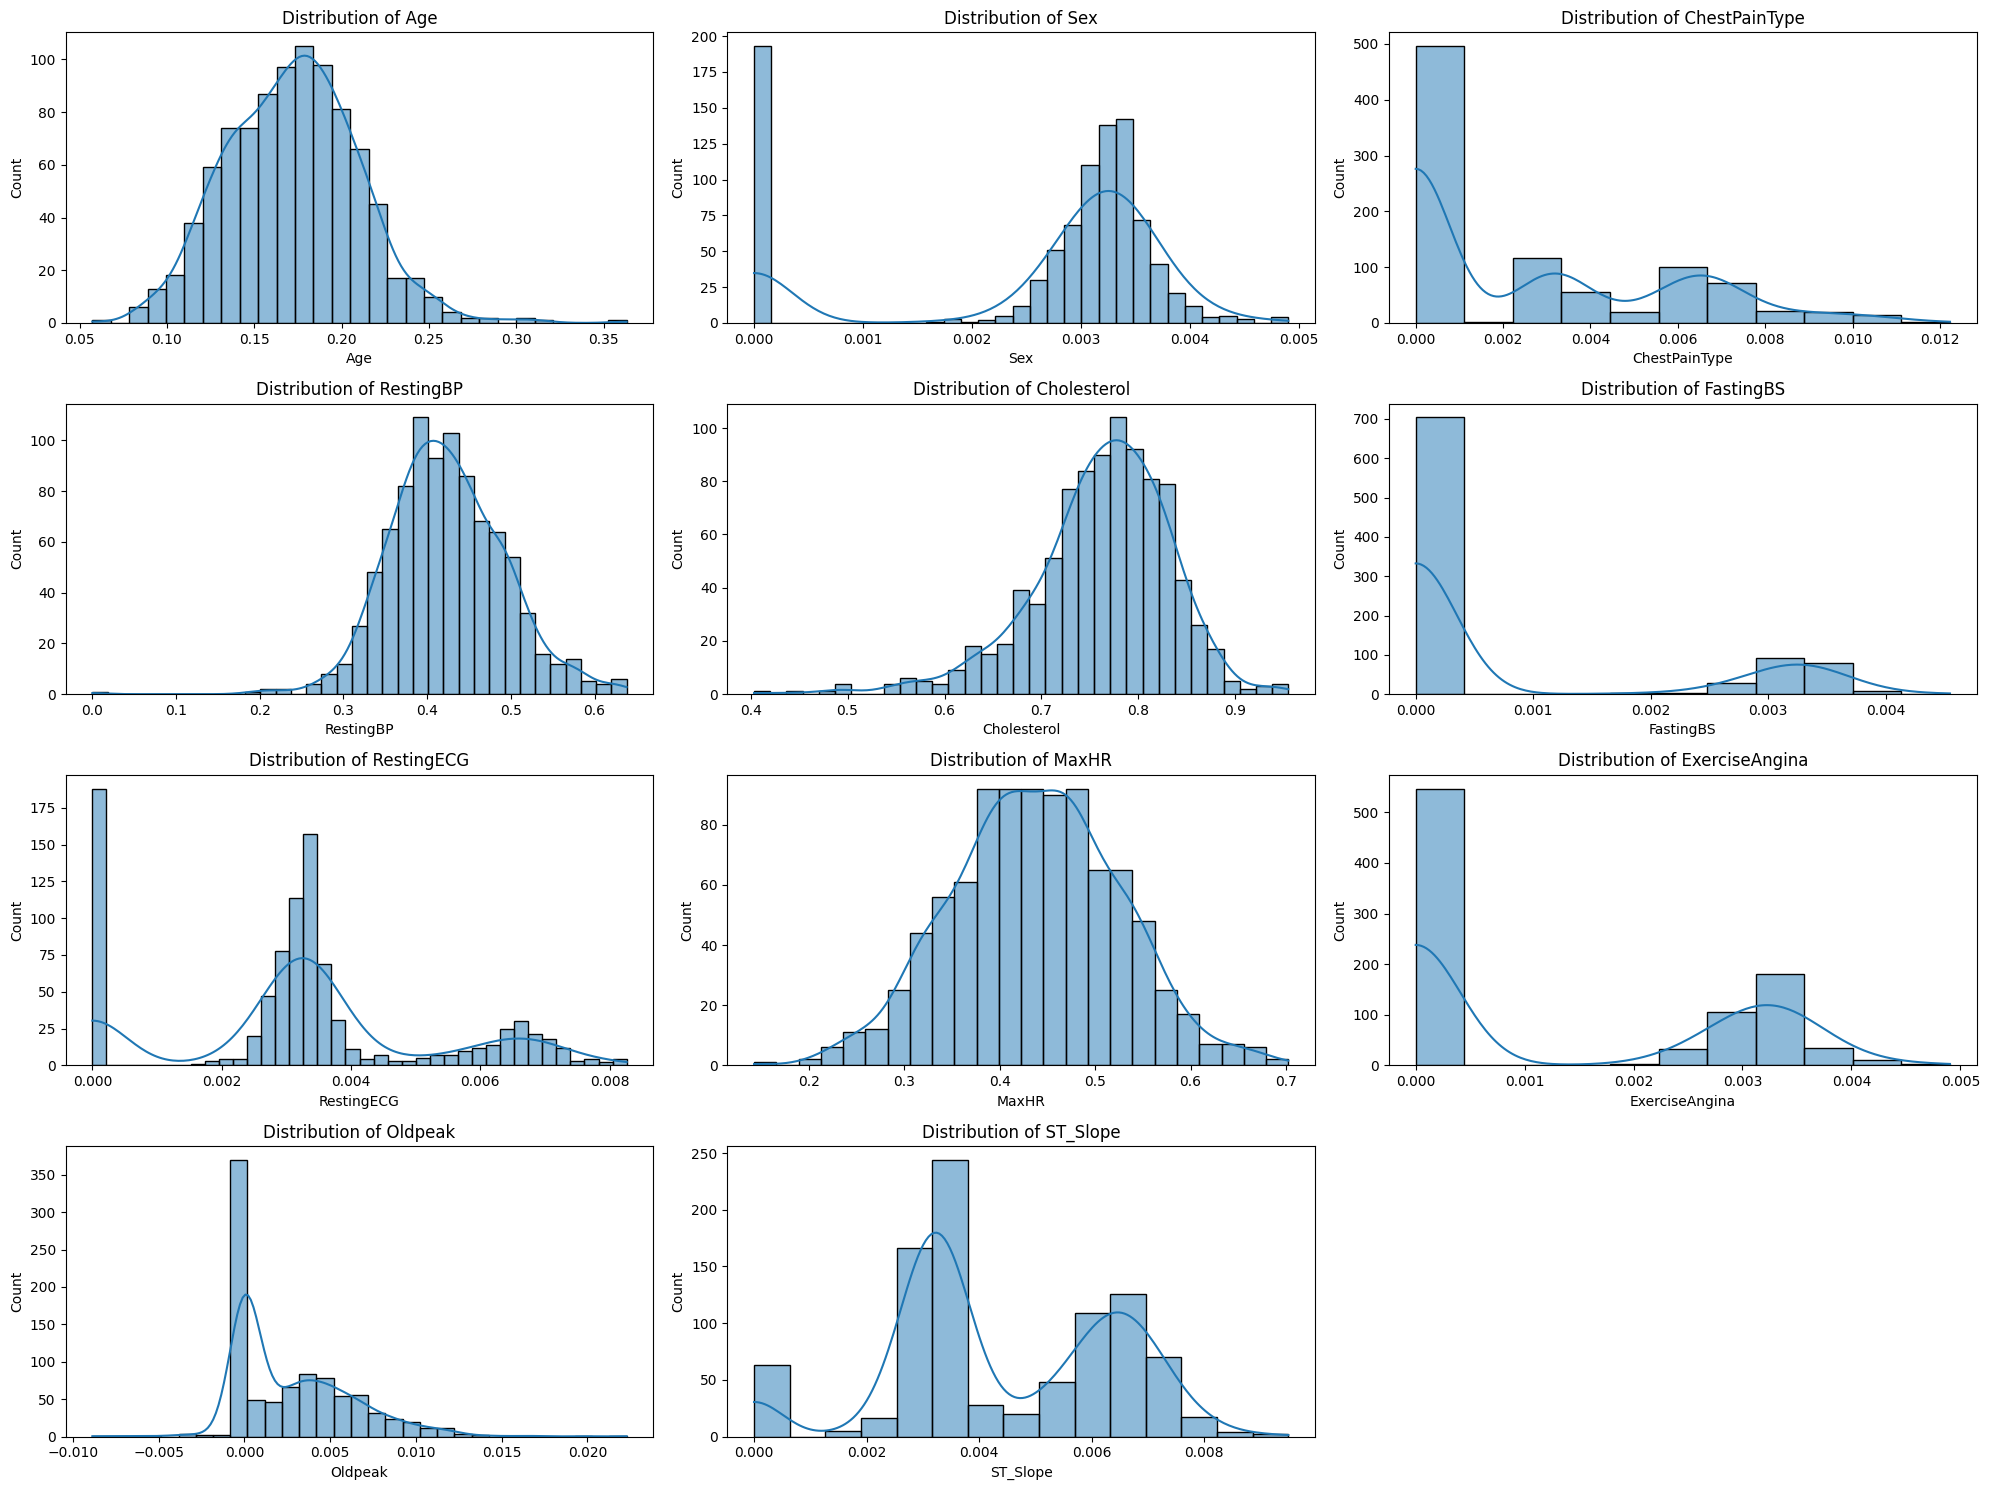

In [ ]:
## Dummy Check that normalization occured as intended. ##

# Visualize distributions of key numerical variables
plt.figure(figsize=(20, 15))

# Select numerical columns for visualization
numerical_cols = norm_df.select_dtypes(include=[np.number]).columns.tolist()
display(numerical_cols)

# Create a subplot grid
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(norm_df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

In [ ]:
U, S, VT = np.linalg.svd(X_norm)
S

array([30.0118389 ,  3.34917032,  2.27542873,  0.92980879,  0.11003126,
        0.08715702,  0.06204141,  0.04899584,  0.04093723,  0.04022761,
        0.03487747])

We will keep the first $9$ values in $\Sigma$ as they correspond to the vast majority of information in the data.

In [ ]:
V = VT.T
V_9 = V[:, :9]
X_reduced = X_norm @ V_9
X_reconstructed = X_reduced @ V_9.T
X_reconstructed.shape

(918, 11)

In [ ]:
for i in range(len(df.columns)-1):
  X_reconstructed[:, i] += X[:, 1].mean()

X_reconstructed

array([[0.89890717, 0.79184442, 0.79252899, ..., 0.79030429, 0.78972206,
        0.79534524],
       [0.95806347, 0.79126828, 0.79664062, ..., 0.78921853, 0.79342833,
        0.79374526],
       [0.90236601, 0.79186929, 0.79285765, ..., 0.7905206 , 0.78969931,
        0.79599919],
       ...,
       [1.04329804, 0.79489595, 0.78975572, ..., 0.79389678, 0.7951916 ,
        0.79438399],
       [0.96471481, 0.79116615, 0.7928415 , ..., 0.78927042, 0.78998039,
        0.79336021],
       [0.92323991, 0.79265777, 0.79680921, ..., 0.79017817, 0.78970396,
        0.79678964]])

<Axes: >

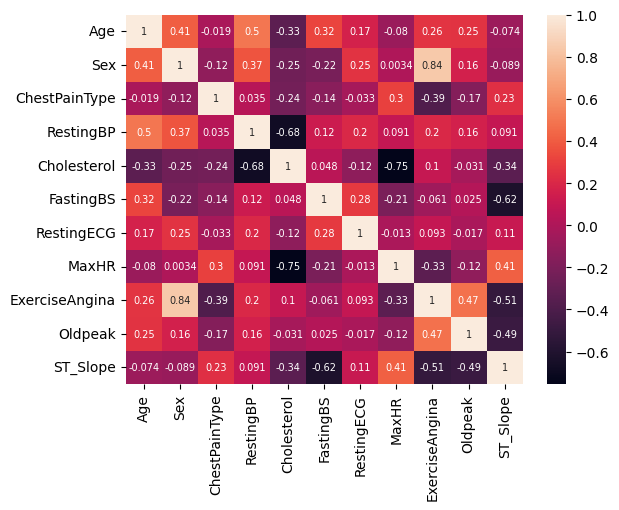

In [ ]:
df_reconstructed = pd.DataFrame(X_reconstructed, columns=df.columns[:-1])
df_reconstructed
corr = df_reconstructed.corr()
sns.heatmap(corr,annot=True,annot_kws={"size": 7})

In [ ]:
df_reconstructed.describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.961765,0.792324,0.792272,1.213574,1.551624,0.790507,0.792968,1.227176,0.791059,0.792594,0.794136
std,0.037488,0.000938,0.003118,0.069161,0.071635,0.000779,0.002095,0.087407,0.001417,0.003457,0.001985
min,0.847077,0.789930,0.789506,0.789760,1.193302,0.788221,0.789443,0.932003,0.787843,0.780791,0.789068
25%,0.933664,0.791652,0.789765,1.168313,1.516407,0.789943,0.792339,1.169014,0.790218,0.789779,0.792820
50%,0.962607,0.792292,0.789863,1.210121,1.560153,0.790399,0.793018,1.227639,0.790641,0.791538,0.793661
75%,0.986108,0.792978,0.795179,1.257833,1.598706,0.790951,0.793510,1.284813,0.792444,0.794719,0.795891
max,1.152987,0.795408,0.802027,1.428141,1.744314,0.793363,0.798051,1.492322,0.794334,0.812190,0.799447


# Splitting the dataset
We split the dataset into train/validate/test sets. We use the original, un-normalized data in order to prevent data leakage, so the test data does not influence our model. Our train/test split is 80/20.

In [ ]:
# Split data
train_X, test_X, train_y, test_y = train_test_split(X,data[:, -1], test_size=0.2, random_state=42)

# Now normalize data - using standardization/z-score normalization
# scaler = sklearn.preprocessing.StandardScaler()
# train_X = scaler.fit_transform(train_X)
# test_X = scaler.transform(test_X)

# Baseline Model
For simple baseline models, we use the ```DummyClassifier``` from ```sklearn.dummy```. Input features are ignored, and predictions are provided either at random or via a rule (for example, always predicting the majority class). These models will serve as a baseline to compare the performance of the actual models we are applying to our dataset.

Majority Classifier Accuracy: 0.5815217391304348 
Majority Calssifier Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        77
         1.0       0.58      1.00      0.74       107

    accuracy                           0.58       184
   macro avg       0.29      0.50      0.37       184
weighted avg       0.34      0.58      0.43       184

Uniform Classifier Accuracy: 0.4782608695652174 
Uniform Calssifier Report: 
               precision    recall  f1-score   support

         0.0       0.39      0.45      0.42        77
         1.0       0.56      0.50      0.52       107

    accuracy                           0.48       184
   macro avg       0.48      0.47      0.47       184
weighted avg       0.49      0.48      0.48       184

Stratified Classifier Accuracy: 0.4782608695652174 
Stratified Calssifier Report: 
               precision    recall  f1-score   support

         0.0       0.37      0.36      0.37      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


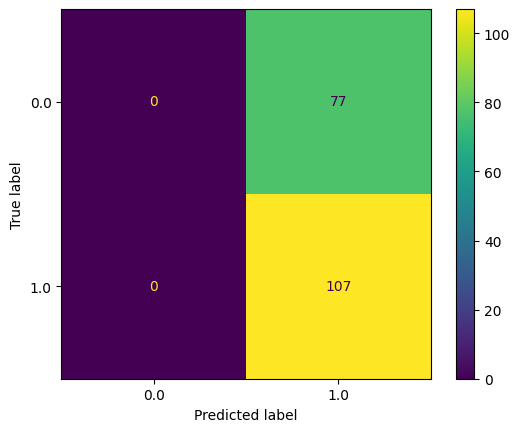

In [ ]:
##  Majority Classifier: Always predicts most frequent class label  ##
# Create the majority classifier
majority_clf = DummyClassifier(strategy='most_frequent',random_state=42)
# Fit the classifier on the training data
majority_clf.fit(train_X, train_y)
# Make predictions on the test data
y_pred_majority = majority_clf.predict(test_X)
# Calculate evaluation metrics
majority_accuracy = accuracy_score(test_y,y_pred_majority)
majority_report = classification_report(test_y, y_pred_majority)
print("Majority Classifier Accuracy:",majority_accuracy,"\nMajority Calssifier Report: \n",majority_report)
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_majority)


##  Uniform Classifier: Randomly predicts, with each class having equal probability  ##
uniform_clf = DummyClassifier(strategy='uniform',random_state=42)
# Create the uniform classifier
uniform_clf.fit(train_X, train_y)
# Make predictions on the test data
y_pred_uniform = uniform_clf.predict(test_X)
# Calculate evaluation metrics
uniform_accuracy = accuracy_score(test_y,y_pred_uniform)
uniform_report = classification_report(test_y, y_pred_uniform)
print("Uniform Classifier Accuracy:",uniform_accuracy,"\nUniform Calssifier Report: \n",uniform_report)

##  Stratified Classifier: Randomly predicts but keeps the original label distribution  ##
stratified_clf = DummyClassifier(strategy='stratified',random_state=42)
# Create the stratified classifier
stratified_clf.fit(train_X, train_y)
# Make predictions on the test data
y_pred_strat = stratified_clf.predict(test_X)
# Calculate evaluation metrics
stratified_accuracy = accuracy_score(test_y,y_pred_strat)
stratified_report = classification_report(test_y, y_pred_strat)
print("Stratified Classifier Accuracy:",stratified_accuracy,"\nStratified Calssifier Report: \n",stratified_report)



The majority classifier had the best accuracy, though by nature had 0 scores for precision, recall, and f-1 for the minority class. (Technicially it is undefined for the F-1 score, as the warnings tell us, and this is because the minority class is never predicted by the model and leads to a zero division error.)

Between the stratified and uniform classifiers, which had the same accuracy, the uniform classifier performed slightly better.

We can use these scores as a baseline when evaluating our actual machine learning models. We want to ensure that our models are more accurate than simply guessing the majority class each time, and that our classifications are overall better than random guessing (as in the uniform classifier).

# Support Vector Machine
As sklearn's SVM is optimized, we'll use it with with a SKlearn pipeline.

In [ ]:
SVC_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC())
])

untuned_model = SVC().fit(train_X, train_y)
y_pred_untuned = untuned_model.predict(test_X)
untuned_accuracy = accuracy_score(test_y, y_pred_untuned)
print(f"Untuned accuracy: {untuned_accuracy}")
print()
print("Majority Classifier Accuracy:",majority_accuracy)
print("Uniform Classifier Accuracy:",uniform_accuracy)
print("Stratified Classifier Accuracy:",stratified_accuracy)

Untuned accuracy: 0.6793478260869565

Majority Classifier Accuracy: 0.5815217391304348
Uniform Classifier Accuracy: 0.4782608695652174
Stratified Classifier Accuracy: 0.4782608695652174


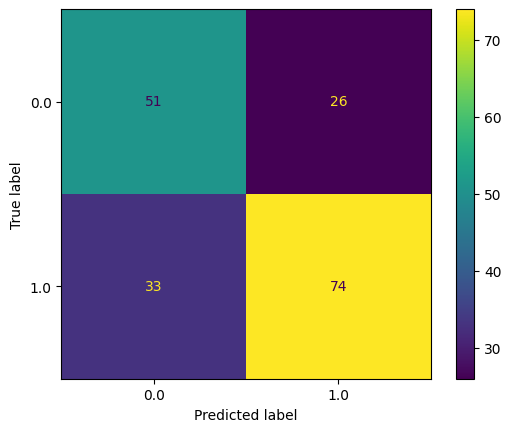

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_untuned)

As we can see, our SVM model's accuracy is already better than the majority classifier.

## Hyper-parameter tuning

In [ ]:

# ## NO NEED TO RUN THIS AS RESULTS HAVE BEEN FOUND ##

# param_grid = {
#     'pca__n_components': list(range(1, len(df.columns))),

#     'svm__C': [0.1, 1, 10, 100],
#     'svm__gamma': [1, 0.1, 0.01, 0.001],
#     'svm__kernel': ['rbf', 'poly', 'sigmoid']
# }

# grid_search = GridSearchCV(
#     estimator = SVC_pipeline,
#     param_grid = param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=3,
#     n_jobs=-1)

# grid_search.fit(train_X, train_y)

# print("Best parameters found: ", grid_search.best_params_)

Output from the above:

`Best parameters found:  {'pca__n_components': 10, 'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}`

Let's plug that into our pipeline and see our accuracy compared to our untuned model.

In [ ]:
SVC_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('svm', SVC(C= 1, gamma= 0.1, kernel='rbf'))
])

SVC_pipeline.fit(train_X, train_y)

tuned_SVM_pred = SVC_pipeline.predict(test_X)
accuracy = accuracy_score(test_y, tuned_SVM_pred)
print(f"Tuned SVM accuracy: {accuracy}")
print(f"Untuned SVM accuracy: {untuned_accuracy}")

Tuned SVM accuracy: 0.8641304347826086
Untuned SVM accuracy: 0.6793478260869565


In [ ]:
svm_report = classification_report(test_y,tuned_SVM_pred)
print(svm_report)

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84        77
         1.0       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



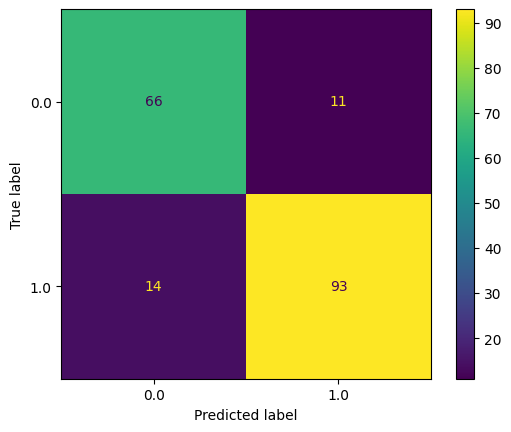

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, tuned_SVM_pred)

In short, our tuned model had $19$ less false negatives and $15$ less false positive.

# Logistic Regression

## Raw and Untuned Logistic Regressions

In [ ]:
# from sklearn.linear_model import LogisticRegression

LR_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('LR', LogisticRegression())
])

LR_pipeline.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('LR', LogisticRegression())])

In [ ]:
raw_logreg = LogisticRegression(max_iter=1000)
raw_logreg.fit(train_X, train_y)

raw_logreg_pred = raw_logreg.predict(test_X)
raw_logreg_accuracy = accuracy_score(test_y, raw_logreg_pred)

print(f'Raw Logistic Regression Accuracy: {raw_logreg_accuracy}\n')

Raw Logistic Regression Accuracy: 0.842391304347826



In [ ]:
logreg_pred = LR_pipeline.predict(test_X)
logreg_accuracy = accuracy_score(test_y, logreg_pred)
logreg_report = classification_report(test_y,logreg_pred)

print(f'Untuned Logistic Regression Accuracy: {logreg_accuracy}\n')

print(logreg_report)

Untuned Logistic Regression Accuracy: 0.8532608695652174

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83        77
         1.0       0.91      0.83      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



Original Data Untuned Logistic Regression Accuracy: $0.8478260869565217$

Our untuned logistic regression is doing slightly worse than our tuned SVM but better than our untuned SVM.

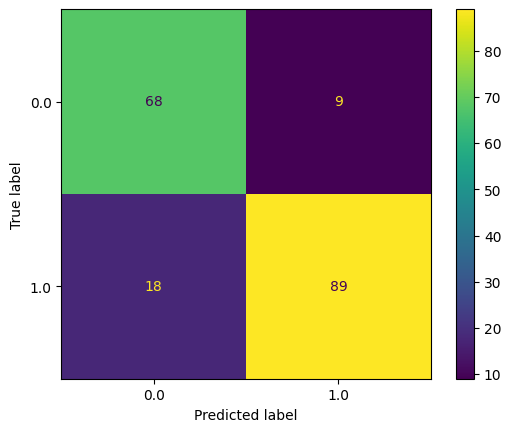

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, logreg_pred)

## Hyper-parameter tuning

Only `liblinear` and `lbfgs` are good solvers for our dataset (which is somewhat small), so the others aren't needed.

`lbfgs` only supports `l2` regularization.

In [ ]:
param_grid = {
    'pca__n_components': list(range(1, len(df.columns))),#[8, 9, 10],

    'LR__solver': ['lbfgs'],
    'LR__penalty': ['l2', None],
    'LR__C': [0.001, 0.1, 1, 10, 10],
    'LR__max_iter': [100, 1000]
}

grid_search = GridSearchCV(
    estimator = LR_pipeline,
    param_grid = param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1)

grid_search.fit(train_X, train_y)

print("Best parameters found: ", grid_search.best_params_)

l2_pca_components = list(grid_search.best_params_.values())[-1]

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
Best parameters found:  {'LR__C': 0.1, 'LR__max_iter': 100, 'LR__penalty': 'l2', 'LR__solver': 'lbfgs', 'pca__n_components': 7}


We do a second grid search with `liblinear` and `l1` instead.

In [ ]:
param_grid = {
    'pca__n_components': list(range(1, len(df.columns))),#[8, 9, 10],

    'LR__solver': ['liblinear'],
    'LR__penalty': ['l1'],
    'LR__C': [0.001, 0.1, 1, 10, 10],
    'LR__max_iter': [100, 1000]
}

grid_search = GridSearchCV(
    estimator = LR_pipeline,
    param_grid = param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1)

grid_search.fit(train_X, train_y)
print("Best parameters found: ", grid_search.best_params_)
l1_pca_components = list(grid_search.best_params_.values())[-1]

# print(max_k,l2_pca_components,l1_pca_components)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
Best parameters found:  {'LR__C': 10, 'LR__max_iter': 100, 'LR__penalty': 'l1', 'LR__solver': 'liblinear', 'pca__n_components': 7}


Applying the best parameters to our model

In [ ]:
# l2 search
l2_LR_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=l2_pca_components)),
    ('LR', LogisticRegression(C=0.1, max_iter=100, penalty='l2',
                              solver='lbfgs'))
])

# l1 search
l1_LR_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=l1_pca_components)),
    ('LR', LogisticRegression(C=1, max_iter=100, penalty='l2',
                              solver='liblinear'))
])

l2_LR_model = l2_LR_pipeline.fit(train_X, train_y)
l1_LR_model = l1_LR_pipeline.fit(train_X, train_y)

l2_LR_pred = l2_LR_model.predict(test_X)
l1_LR_pred = l1_LR_model.predict(test_X)

l2_LR_accuracy = accuracy_score(test_y, l2_LR_pred)
l1_LR_accuracy = accuracy_score(test_y, l1_LR_pred)

l2_LR_report = classification_report(test_y, l2_LR_pred)
l1_LR_report = classification_report(test_y, l1_LR_pred)

print(f'l2 Logistic Regression Accuracy: {l2_LR_accuracy}\n')
print(f'l2 Logistic Regression Report: {l2_LR_report}\n')
print(f'l1 Logistic Regression Accuracy: {l1_LR_accuracy}\n')
print(f'l1 Logistic Regression Report: {l1_LR_report}\n')

l2 Logistic Regression Accuracy: 0.8478260869565217

l2 Logistic Regression Report:               precision    recall  f1-score   support

         0.0       0.78      0.88      0.83        77
         1.0       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184


l1 Logistic Regression Accuracy: 0.8478260869565217

l1 Logistic Regression Report:               precision    recall  f1-score   support

         0.0       0.78      0.88      0.83        77
         1.0       0.91      0.82      0.86       107

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184




Unfortunately, our $l_1$ model didn't improve over the baseline.

With median cholesterol (for both): $0.8478260869565217$

Unfortunately, tuning our Logistic Regression didn't improve anything!
Also, both l1 and l2 behaved exactly the same.

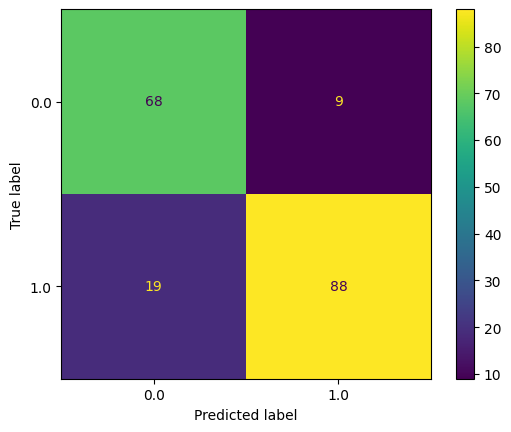

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, l2_LR_pred)

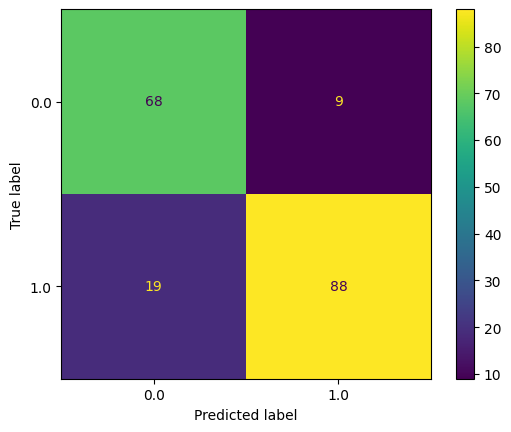

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, l1_LR_pred)

Compared to our best SVM model, our best Logistic Regression had less false positives but more false negatives.

# Decision Tree

## SKLearn Implementation

In [ ]:
##  Decision Tree  ##

DTree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

DTree_pipeline.fit(train_X, train_y)

y_pred_untuned_dtree = DTree_pipeline.predict(test_X)
dtree_accuracy = accuracy_score(test_y, y_pred_untuned_dtree)
dtree_report = classification_report(test_y, y_pred_untuned_dtree)
print(dtree_accuracy,"\n",dtree_report)

0.7608695652173914 
               precision    recall  f1-score   support

         0.0       0.69      0.77      0.73        77
         1.0       0.82      0.76      0.79       107

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.76      0.76       184



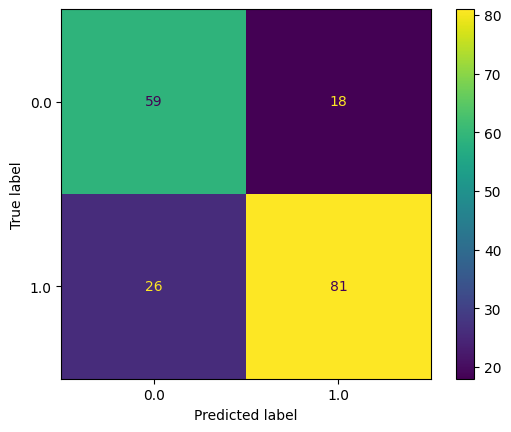

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_untuned_dtree)

From original dataset, accuracy = $0.8097826086956522$

With median cholesterol: $0.7336956521739131$

With no cholesterol: $0.7717391304347826$

### Hyperparameter Tuning

In [ ]:
param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'pca__n_components': list(range(1, len(df.columns))),
    'dt__max_depth': [3, 5, 7, 10, None],
    'dt__min_samples_split': [10, 20, 50],
    'dt__min_samples_leaf': [2, 5, 10, 20],
    'dt__max_features': ['sqrt', 'log2', None],
    'dt__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=DTree_pipeline,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(train_X, train_y)
dt_best_params = grid_search.best_params_
print("Best parameters found: ", dt_best_params)

Best parameters found:  {'dt__class_weight': None, 'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 50, 'pca__n_components': 2}


In [ ]:
dtree_best_estimator = grid_search.best_estimator_

y_pred_dtree = dtree_best_estimator.predict(test_X)
dtree_accuracy = accuracy_score(test_y, y_pred_dtree)
dtree_report = classification_report(test_y, y_pred_dtree)
print(dtree_accuracy,"\n",dtree_report)

0.7989130434782609 
               precision    recall  f1-score   support

         0.0       0.70      0.92      0.79        77
         1.0       0.93      0.71      0.80       107

    accuracy                           0.80       184
   macro avg       0.81      0.82      0.80       184
weighted avg       0.83      0.80      0.80       184



## XGBoost Implementation

In [ ]:
from xgboost import XGBClassifier

XGB_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('xgb', XGBClassifier(n_jobs=-1))
])

XGB_pipeline.fit(train_X, train_y)

y_pred_xgb_untuned = XGB_pipeline.predict(test_X)

xgb_untuned_accuracy = accuracy_score(test_y, y_pred_xgb_untuned)
xgb_untuned_report = classification_report(test_y, y_pred_xgb_untuned)

display(xgb_untuned_accuracy)
print(xgb_untuned_report)

0.8641304347826086

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        77
         1.0       0.91      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184



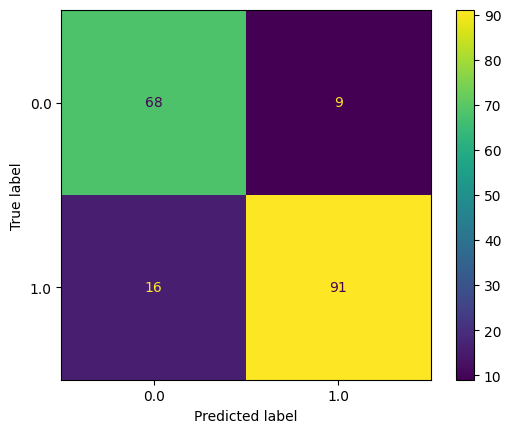

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_xgb_untuned)

### Hyper-parameter tuning

In [ ]:
param_grid = {
    'pca__n_components': list(range(8, len(df.columns))),

    'xgb__n_estimators': [10, 100,200],
    'xgb__learning_rate': [0.01, 0.1, 1],
    'xgb__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator = XGB_pipeline,
    param_grid = param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1)


# Do not run
# grid_search.fit(train_X, train_y)
# print("Best parameters found: ", grid_search.best_params_)

best_params = {'pca__n_components': 10, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
best_params

{'pca__n_components': 10,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100}

In [ ]:
XGB_tuned_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=11)),
    ('xgb', XGBClassifier(n_jobs=-1,
                          learning_rate=0.1, max_depth=5, n_estimators=100))
])

XGB_tuned_pipeline.fit(train_X, train_y)

y_pred_xgb_tuned = XGB_tuned_pipeline.predict(test_X)

xgb_tuned_accuracy = accuracy_score(test_y, y_pred_xgb_tuned)
xgb_tuned_report = classification_report(test_y, y_pred_xgb_tuned)

display(xgb_tuned_accuracy)
print(xgb_untuned_report)

0.8586956521739131

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        77
         1.0       0.91      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184



Our tuning is not as strong as untuned, so we messed up somewhere along the line.

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

RF_pipeline.fit(train_X, train_y)

y_pred_rf_untuned = RF_pipeline.predict(test_X)
rf_untuned_accuracy = accuracy_score(test_y, y_pred_rf_untuned)
rf_untuned_report = classification_report(test_y, y_pred_rf_untuned)

display(rf_untuned_accuracy)
print(rf_untuned_report)

0.8152173913043478

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79        77
         1.0       0.88      0.79      0.83       107

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.82      0.82      0.82       184



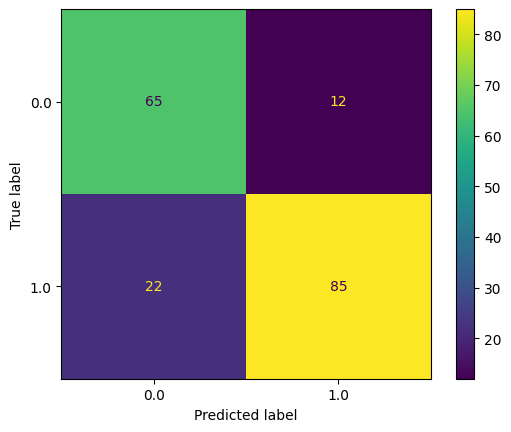

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf_untuned)

Our random forest did not do as well as our `XGBoost` tree.

## Hyper-parameter tuning

In [ ]:
param_grid = {
    'pca__n_components': list(range(1, len(df.columns))),

    'rf__n_estimators': [10, 100, 500],
    'rf__criterion': ['gini', 'entropy', 'log_loss'],
    'rf__max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    estimator = RF_pipeline,
    param_grid = param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1)

# Do not run unless you want to wait 15 minutes
# grid_search.fit(train_X, train_y)
# rf_best_estimator = grid_search.best_estimator_
# y_pred_best_rf = rf_best_estimator.predict(test_X)
# best_rf_accuracy = accuracy_score(test_y, y_pred_best_rf)
# best_rf_report = classification_report(test_y, y_pred_best_rf)
# print(best_rf_accuracy,"\n",best_rf_report)

# print("Best parameters found: ", grid_search.best_params_)
best_params = {'pca__n_components': 10, 'rf__criterion': 'entropy', 'rf__max_features': 'sqrt', 'rf__n_estimators': 100}
best_params

{'pca__n_components': 10,
 'rf__criterion': 'entropy',
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 100}

In [ ]:
tuned_RF_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1,
                                  criterion='entropy', max_features = 'sqrt',
                                  n_estimators=100))
])

tuned_RF_pipeline.fit(train_X, train_y)

y_pred_rf_tuned = tuned_RF_pipeline.predict(test_X)
rf_tuned_accuracy = accuracy_score(test_y, y_pred_rf_tuned)
rf_tuned_report = classification_report(test_y, y_pred_rf_tuned)

display(rf_tuned_accuracy)
print(rf_tuned_report)

0.8260869565217391

              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81        77
         1.0       0.89      0.79      0.84       107

    accuracy                           0.83       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.84      0.83      0.83       184



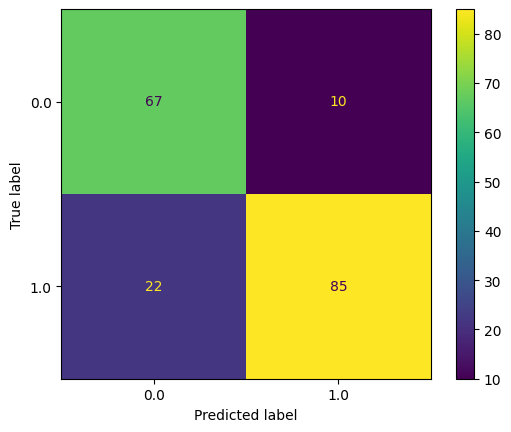

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_rf_tuned)

# "Super" model
So far we have two contenders for best model. Overall, our untuned `XGBoost` decision tree corresponding to `XGB_pipeline` and our tuned SVM corresponding to `SVC_pipeline` have the same accuracy.

However our `XGBoost`tree has better precision. We can use this to build a better model combining the two, creating a "super" model.

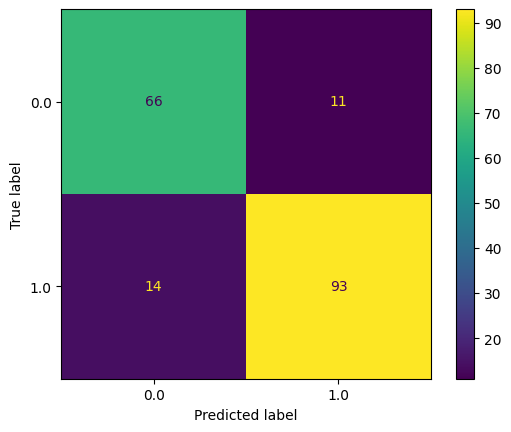

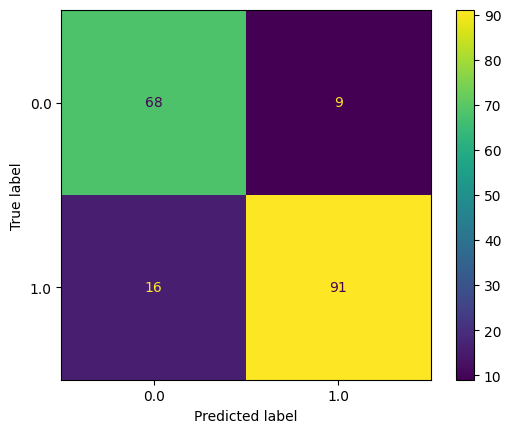

In [ ]:
# For reference

ConfusionMatrixDisplay.from_predictions(test_y, tuned_SVM_pred)
ConfusionMatrixDisplay.from_predictions(test_y, y_pred_xgb_untuned)

In [ ]:
print(f'Tuned SVM accuracy: {accuracy}')
print(f'Tuned XGB accuracy: {xgb_untuned_accuracy}')
print('')

SVM_precision = sklearn.metrics.precision_score(test_y, tuned_SVM_pred)
XGB_precision = sklearn.metrics.precision_score(test_y, y_pred_xgb_untuned)

print(f'Tuned SVM precision: {SVM_precision}')
print(f'Tuned XGB precision: {XGB_precision}')

Tuned SVM accuracy: 0.8641304347826086
Tuned XGB accuracy: 0.8641304347826086

Tuned SVM precision: 0.8942307692307693
Tuned XGB precision: 0.91


We will build our "super" model as follows:



```
if (SVM_model.predict((y_i) == 1):
  use SVM_model.predict(y_i)
use XGB_model.pedict(y_i)
```



In [ ]:
def super_model(X):
  mask = (tuned_SVM_pred==1)#y_pred_xgb_untuned == 1)

  #y_pred_supermodel = np.where(mask, y_pred_xgb_untuned, tuned_SVM_pred)
  y_pred_supermodel = np.where(mask, tuned_SVM_pred, y_pred_xgb_untuned)

  return y_pred_supermodel

In [ ]:
super_model_pred = super_model(test_X)
super_model_accuracy = accuracy_score(test_y, super_model_pred)
super_model_precision = precision_score(test_y, super_model_pred)
super_model_recall = recall_score(test_y, super_model_pred)
super_model_report = classification_report(test_y, super_model_pred)

print(f'Super model accuracy: {super_model_accuracy}')
print(f'Super model precision: {super_model_precision}')
print(f'Super model recall: {super_model_recall}')
print(f'Super model report:\n {super_model_report}')

Super model accuracy: 0.8913043478260869
Super model precision: 0.8990825688073395
Super model recall: 0.9158878504672897
Super model report:
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87        77
         1.0       0.90      0.92      0.91       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



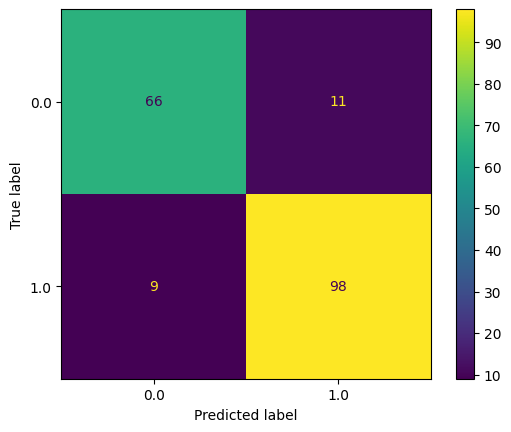

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_y, super_model_pred)

# Conclusion
In short, we went through SVM models, Regression models, Decision Tree models, and Random Forest models. We found our best model was our `XGBoost` Decision Tree, and that our tuned SVM model had higher recall. With this in mind, we developed a "super" model to combine the best aspects of the two to create an even stronger model.

This model had an accuracy of $0.89$, making it our most powerful model out of all those we tried.

In [ ]:
# For evaluation metrics
def evaluate(test,predictions):
  a = round(accuracy_score(test,predictions),4)
  p = round(precision_score(test,predictions),4)
  r = round(recall_score(test,predictions),4)
  f1 = round(f1_score(test,predictions),4)
  auc = round(roc_auc_score(test,predictions),4)
  cr = classification_report(test,predictions,digits=4)
  print("Accuracy:",a,"\nPrecision:",p,"\nRecall:",r,"\nF-1:",f1,
        "\nAUC ROC:",auc,"\nReport:\n",cr)
  #print("\nAUC ROC:",auc,"\nReport:\n",cr)
  return a,p,r,f1,auc,cr

In [ ]:
# Dictionary of model name and predictions
prediction_list = {"Majority":y_pred_majority, "Uniform":y_pred_uniform,
                   "Stratified":y_pred_strat, "SVM":tuned_SVM_pred,
                   "Linear Regression":l2_LR_pred,"Decision Tree":y_pred_dtree,
                   "XGBoost":y_pred_xgb_untuned,"Random Forest":y_pred_rf_tuned,
                   "Super":super_model_pred}
# Display all scores
for key,value in prediction_list.items():
  print(key+":")
  evaluate(test_y,value)


Majority:
Accuracy: 0.5815 
Precision: 0.5815 
Recall: 1.0 
F-1: 0.7354 
AUC ROC: 0.5 
Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        77
         1.0     0.5815    1.0000    0.7354       107

    accuracy                         0.5815       184
   macro avg     0.2908    0.5000    0.3677       184
weighted avg     0.3382    0.5815    0.4276       184

Uniform:
Accuracy: 0.4783 
Precision: 0.5579 
Recall: 0.4953 
F-1: 0.5248 
AUC ROC: 0.4749 
Report:
               precision    recall  f1-score   support

         0.0     0.3933    0.4545    0.4217        77
         1.0     0.5579    0.4953    0.5248       107

    accuracy                         0.4783       184
   macro avg     0.4756    0.4749    0.4732       184
weighted avg     0.4890    0.4783    0.4816       184

Stratified:
Accuracy: 0.4783 
Precision: 0.5505 
Recall: 0.5607 
F-1: 0.5556 
AUC ROC: 0.4622 
Report:
               precision    recall  f1-score  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
